# Identifying Disease Outbreaks

## Discovering Pandemics in the United States and worldwide

__Objective__: Identify pandemics by analyzing the centrally located headlines in the largest clusters of headlines. Look at the prevalence of disease in each cluster. Any disease outbreaks in the United States or around the world will be reported back to superiors at the WHO to direct help where it’s needed. 

__Workflow__:

1.	Separate the data into world and US datasets.
    -	This can be done using the countrycode for each city from geonamescache.
2.	Re-cluster the world and US data separately. 
    -	This may require different clustering parameters for each dataset.
    -	Put your code into functions to quickly cluster and visualize results of the model
3.	Sort the clusters by the number of headlines from largest to smallest.
4.	Sort headlines within each cluster by finding headlines closest to the center of the cluster.
    -	You can average the location coordinates in each cluster to get an approximation of the center. If you want to be more accurate, then you’ll need to apply a geographic formula to find the true geographic center of each cluster.
5.	Examine the headlines closest to the center of each cluster. Record any repeated diseases in the headlines. Do this for both the US and the world data. 
    -	If no diseases appear to be repeating, try the clustering again. Also make sure to look at enough headlines within each cluster to find repeated diseases.
6.	Pinpoint disease outbreaks based on repeated diseases within headlines in clusters. Prepare final maps of the United States and the world.
    -	If you find one or two major diseases, you can find all mentions of it in headlines using regular expressions. 
    -	Remove any irrelevant headlines from the map for presentation.

## Read in the Data

We can use Pandas to read in the csv file with our headlines, cities, locations, and assigned clusters from the previous sections. It's a good idea to do a brief visual and statistical inspection of the data.

In [1]:
import pandas as pd

data = pd.read_csv("./data/processed_headlines_clustered.csv", index_col=0).drop(
    columns=["accented_city", "pop"])

data[['headline', 'city', 'latitude', 'longitude', 'countrycode', 'cluster']].head()

headline           city  latitude  \
0                 Zika Outbreak Hits Miami          Miami  25.77427   
1          Could Zika Reach New York City?  New York City  40.71427   
2        First Case of Zika in Miami Beach    Miami Beach  25.79065   
3  Mystery Virus Spreads in Recife, Brazil         Recife  -8.05389   
4  Dallas man comes down with case of Zika         Dallas  32.78306   

   longitude countrycode  cluster  
0  -80.19366          US        0  
1  -74.00597          US        0  
2  -80.13005          US        0  
3  -34.88111          BR        1  
4  -96.80667          US        0

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605 entries, 0 to 646
Data columns (total 8 columns):
headline       605 non-null object
city           605 non-null object
latitude       605 non-null float64
longitude      605 non-null float64
countrycode    605 non-null object
cluster        605 non-null int64
x              605 non-null float64
y              605 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 42.5+ KB


### Split Datasets

Splitting into the US and World is easy because we have the country codes.

In [2]:
us_data = data[data["countrycode"] == "US"].copy()
world_data = data[data["countrycode"] != "US"].copy()

print(f"There are {len(us_data)} headlines in the US.")
print(f"There are {len(world_data)} headlines outside the US.")

There are 305 headlines in the US.
There are 300 headlines outside the US.


# Re-Cluster the Data

Let's apply the DBSCAN clustering method to both datasets separately. This may require different parameters due to the headline distribution; headlines in the United States are more dense than the world headlines.

In [3]:
def cluster_location(clusterer, data, lat_string="latitude", lon_string="longitude"):
    """
    Fit a clustering algorithm on location data.
    """
    features = data[[lat_string, lon_string]].copy()
    clusterer.fit(features)
    # Assign the cluster labels
    data["cluster"] = clusterer.labels_
    return data

For the United States, `min_samples` will be 10 cities, and the distance between clusters, `eps`, will be 3 (which doesn't have a unit.

In [4]:
from sklearn.cluster import DBSCAN

us_clusterer = DBSCAN(eps=3, min_samples=10)
us_data = cluster_location(us_clusterer, us_data)
us_data['cluster'].value_counts()

 1    74
 3    57
-1    51
 4    45
 0    42
 2    21
 5    10
 6     5
Name: cluster, dtype: int64

The rest of the world headlines are more spread out, so we will allow greater distance between headlines, setting `eps` to 10. We will also decrease the number of headlines needed in a cluster to 8.

In [5]:
world_clusterer = DBSCAN(eps=10, min_samples=8)
world_data = cluster_location(world_clusterer, world_data)
world_data['cluster'].value_counts()

-1    76
 1    60
 2    59
 3    52
 0    22
 5    11
 4    11
 6     9
Name: cluster, dtype: int64

We still see a number of headlines that have a label of -1 meaning no cluster. According to the DBSCAN documentation, these points represent noise and should not be placed in a cluster. We can remove these for the final presentation.

## Visualizations

Let's examine the headline locations on a map. We'll use this [Stack Overflow answer](https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states) to plot the US only with Basemap. The world can be plotted as in the previous section.

In [6]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 20

# %#matplotlib inline

# Map of only the continental US
us_m = Basemap(
    llcrnrlon=-119,
    llcrnrlat=22,
    urcrnrlon=-64,
    urcrnrlat=49,
    projection="lcc",
    lat_1=33,
    lat_2=45,
    lon_0=-95,
)

# Convert to map coordinates
us_data["x"], us_data["y"] = us_m(
    x=list(us_data["longitude"]), y=list(us_data["latitude"])
)

# Entire world
world_m = Basemap()

# Convert to map coordinates
world_data["x"], world_data["y"] = world_m(
    x=list(world_data["longitude"]), y=list(world_data["latitude"])
)

The following function is a slight modification from that used in previous section. It plots the United States with state boundaries if we specify the option.

In [7]:
cluster_color_mapping = {
    -1: "k",
    0: "blue",
    1: "green",
    2: "brown",
    3: "purple",
    4: "red",
    5: "orange",
    6: "cyan",
    7: "gray",
}


def plot_clusters(
    data, plot_us=False, label_outbreak=None, cluster_centers=None, return_ax=False
):
    """
    Plot headline data and clusters either for the us or the world. Optionally
    plot the outbreaks and/or the cluster centers
    """
    plt.figure(figsize=(20, 14))
    plt.rcParams["font.size"] = 24

    if plot_us:
        # Read in states and draw map
        us_m.readshapefile("./data/st99_d00_shp/st99_d00", "states")
        us_m.shadedrelief()

    else:
        world_m.shadedrelief()
    # Iterate through each cluster and plot
    for cluster, grouped in data.groupby("cluster"):
        cluster_color = cluster_color_mapping[cluster]

        # Used later for plotting Outbreaks
        if label_outbreak:
            label = f"Cluster: {cluster} Outbreak: {label_outbreak[cluster]}"
        else:
            label = f"Cluster: {cluster}"

        # Plot the data points as a scatter plot colored by the cluster membership
        plt.scatter(
            grouped["x"],
            grouped["y"],
            s=80,
            alpha=1,
            marker="o",
            label=label,
            c=cluster_color,
        )

    if cluster_centers:
        # Iterate through the cluster centers
        for cluster in cluster_centers:
            color = cluster_color_mapping[cluster["cluster"]]
            plt.scatter(cluster["x"], cluster["y"], s=300, alpha=1, marker="*", c=color)

    # Add a legend and title
    ax = plt.gca()
    ax.legend(loc=(1, 0))
    if plot_us:
        _ = ax.set_title("Locations of US Headlines")
    else:
        _ = ax.set_title("Locations of World Headlines")

    if return_ax:
        return ax

In [8]:
plot_clusters(us_data, True)

OSError: cannot locate ./data/st99_d00_shp/st99_d00.shp

<Figure size 1440x1008 with 0 Axes>

These clusters make sense as geographically close headlines are in the same cluster. There are a number of outliers and several prominent groups.

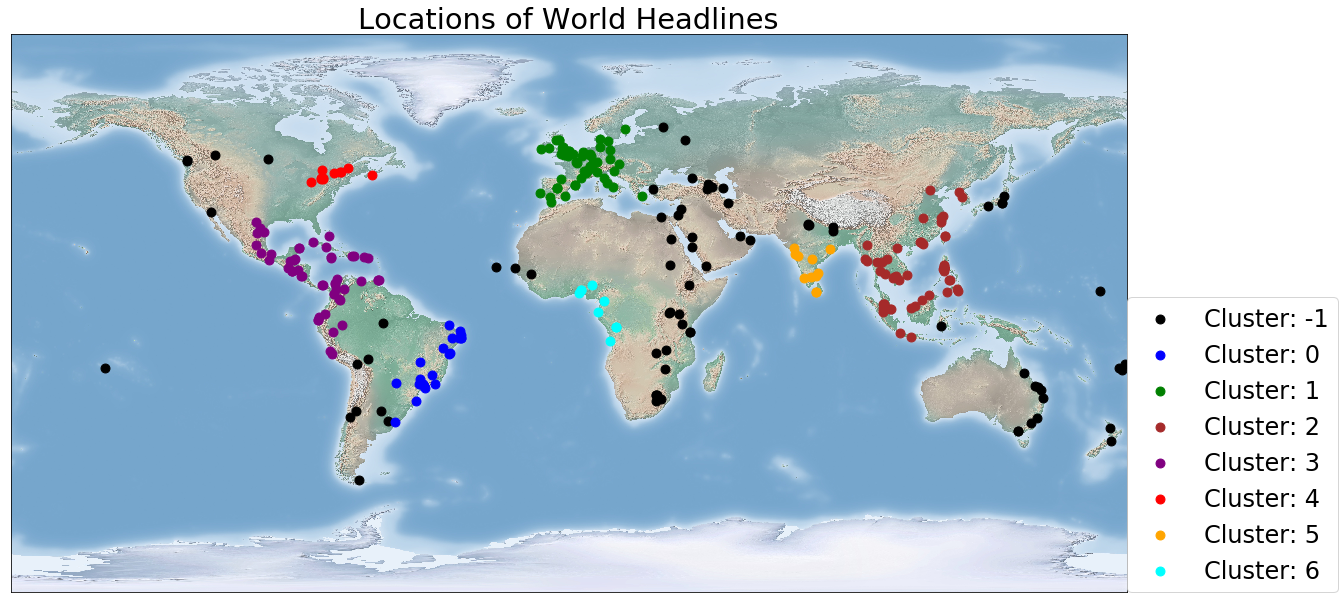

In [10]:
plot_clusters(world_data, False)

The world clusters are also reasonable. We see a number of potential disease outbreaks as well as outlying headlines.

# Analyze World Clusters

We'll start off by examining the world clusters. The first step is to find the center of each cluster. 

## Cluster Centers

To find the centroid of a set of geographic coordinates requires a formula operating on latitude and longitude. This formula is implemented in Python in [this Stack Overflow answer](https://stackoverflow.com/a/57346455/5755357).

In [9]:
import math


def find_centroid(data):
    """
    Calculate the centroid of geographic points.
    
    Based on https://stackoverflow.com/a/57346455/5755357
    """

    x = 0
    y = 0
    z = 0

    # Iterate through each coordinate in radians
    for longitude, latitude in zip(data["longitude"], data["latitude"]):
        longitude, latitude = math.radians(longitude), math.radians(latitude)
        # Convert to a 3D position in radians
        x += math.cos(latitude) * math.cos(longitude)
        y += math.cos(latitude) * math.sin(longitude)
        z += math.sin(latitude)

    # Get the averages of each radians
    n = len(data)
    x /= n
    y /= n
    z /= n

    # Apply formula
    central_longitude = math.atan2(y, x)
    central_square_root = math.sqrt(x ** 2 + y ** 2)
    central_latitude = math.atan2(z, central_square_root)

    # Convert back to degrees
    centroid = dict(
        latitude=math.degrees(central_latitude),
        longitude=math.degrees(central_longitude),
    )
    return centroid

We use this function by segmenting to a specific cluster and passing that cluster's points into the algorithm.

In [10]:
find_centroid(world_data[world_data['cluster'] == 1])

{'latitude': 48.67720650036662, 'longitude': 3.3640328177468484}

## Extract Information about World Clusters

For each cluster outside the US, we'll find the number of points in the cluster and the center of the cluster.

In [11]:
def analyze_clusters(data, data_map):
    """
    Find the centers of each cluster and the number of points in a cluster.
    """
    clusters = []

    # Iterate through each cluster
    for cluster, grouped in data.groupby("cluster"):
        # Find the center location of the cluster
        cluster_centroid = find_centroid(grouped)

        # Convert the center to x, y in the map projection system
        x, y = data_map(cluster_centroid["longitude"], cluster_centroid["latitude"])

        # Record the cluster number, count of points in cluster, and location of cluster center
        clusters.append(
            dict(
                cluster=cluster,
                count=len(grouped),
                longitude=cluster_centroid["longitude"],
                latitude=cluster_centroid["latitude"],
                x=x,
                y=y,
            )
        )

    return clusters


world_clusters = analyze_clusters(world_data, world_m)
world_clusters[:2]

[{'cluster': -1,
  'count': 76,
  'longitude': 55.971290978097166,
  'latitude': 14.622809793813127,
  'x': 55.971290978097166,
  'y': 14.622809793813127},
 {'cluster': 0,
  'count': 22,
  'longitude': -42.856222988193664,
  'latitude': -16.77402502603969,
  'x': -42.856222988193664,
  'y': -16.77402502603969}]

## Visualizing Cluster Centers

We want to make sure we've calculated the cluster centroids correctly. Our visualization function can plot cluster centers if we pass them in.

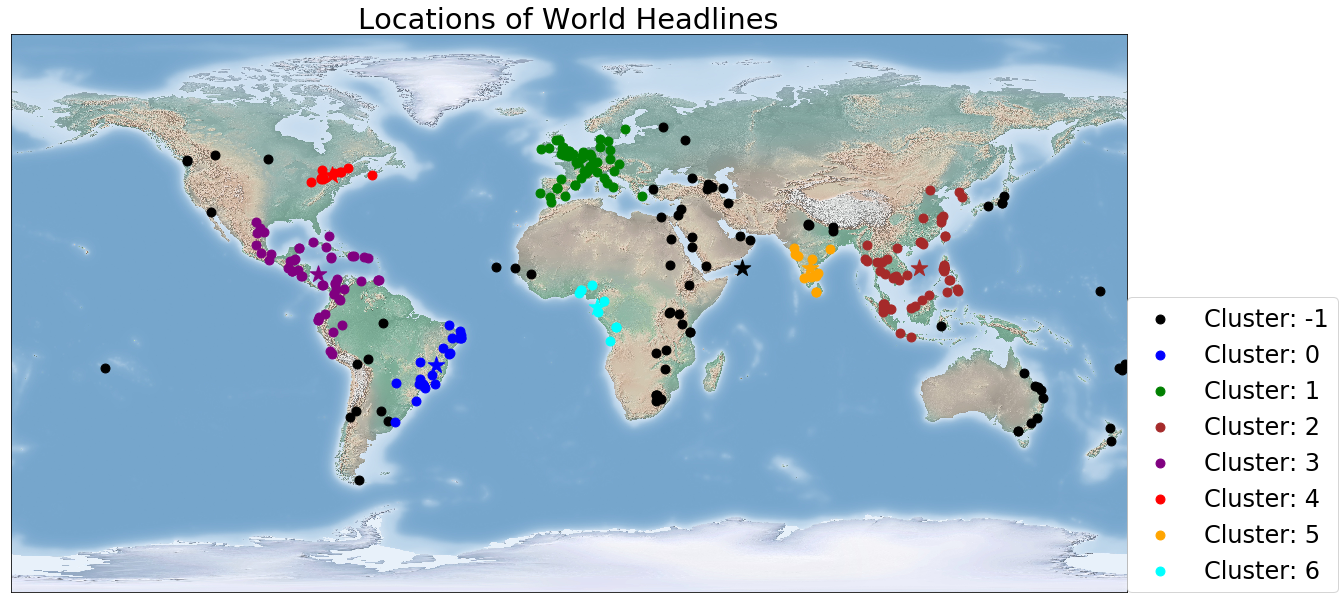

In [12]:
plot_clusters(world_data, cluster_centers=world_clusters)

The cluster centers appear to be correct! We now have the locations of all clusters and their centers for the entire world. The next step is to find the distance of each headline from the cluster centroid to which it is assigned. 

We'll start this process by joining the cluster centers to the data.

In [13]:
world_data = world_data.merge(
    pd.DataFrame(world_clusters), on=["cluster"], suffixes=["", "_cluster_center"]
)
world_data.head()

headline        city  latitude  longitude  \
0  Mystery Virus Spreads in Recife, Brazil      Recife  -8.05389  -34.88111   
1       Zika Infested Monkeys in Sao Paulo   Sao Paulo -23.54750  -46.63611   
2               Zika spreading to Salvador    Salvador -12.97111  -38.51083   
3      Zika outbreak in Piracicaba, Brazil  Piracicaba -22.72528  -47.64917   
4         Second Zika Paitient in Brasilia    Brasilia -15.77972  -47.92972   

  countrycode  cluster         x         y  count  longitude_cluster_center  \
0          BR        0 -34.88111  -8.05389     22                -42.856223   
1          BR        0 -46.63611 -23.54750     22                -42.856223   
2          BR        0 -38.51083 -12.97111     22                -42.856223   
3          BR        0 -47.64917 -22.72528     22                -42.856223   
4          BR        0 -47.92972 -15.77972     22                -42.856223   

   latitude_cluster_center  x_cluster_center  y_cluster_center  
0               -16.774025        -42.856223        -16.774025  
1               -16.774025        -42.856223        -16.774025  
2               -16.774025        -42.856223        -16.774025  
3               -16.774025        -42.856223        -16.774025  
4               -16.774025        -42.856223        -16.774025

## Distance between Headline and Cluster Center

An accurate calculation of the distance on a globe requires using the Great Circle distance. We can use the Haversine formula to calculate the distance along the spherical Earth between each point and the center of the cluster to which it is assigned.

The Haversine Formula is implemented in Python in [this Stack Overflow answer](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points). We'll change the implementation to work on arrays instead of two points.

In [14]:
import numpy as np

def haversine_formula_two_arrays(
    longitude_one, latitude_one, longitude_two, latitude_two
):
    """
    Calculate the Great Circle distance between two points 
    using the Haversine Formula. Latitude and Longitude are in degrees.
    
    Source: https://stackoverflow.com/a/4913653/5755357
    """
    # Convert to radians
    longitude_one, latitude_one, longitude_two, latitude_two = map(
        np.radians, [longitude_one, latitude_one, longitude_two, latitude_two]
    )

    # Apply Haversine formula
    delta_longitude = longitude_two - longitude_one
    delta_latitude = latitude_two - latitude_one
    # Formula
    a = (
        np.sin(delta_latitude / 2) ** 2
        + np.cos(latitude_one) * np.cos(latitude_two) * np.sin(delta_longitude / 2) ** 2
    )
    # Convert from radians to km
    d = 2 * np.arcsin(np.sqrt(a))
    radius_miles = 3956
    return d * radius_miles

We can quickly find the distance between every point and it's respective cluster center in one call to the function.

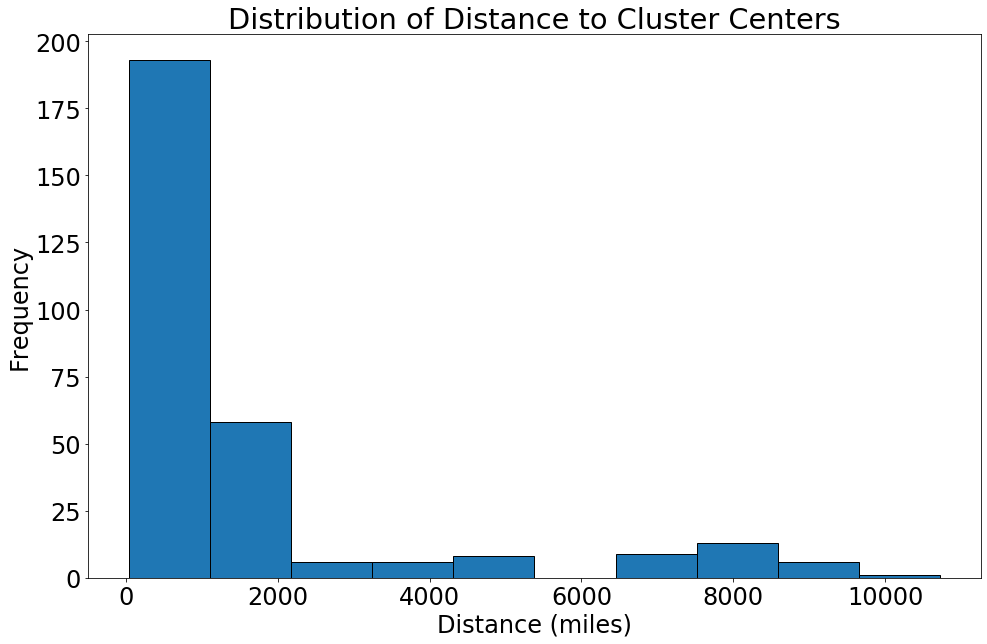

In [15]:
world_data["distance"] = haversine_formula_two_arrays(
    world_data["longitude"],
    world_data["latitude"],
    world_data["longitude_cluster_center"],
    world_data["latitude_cluster_center"],
)
_ = world_data["distance"].plot.hist(
    title="Distribution of Distance to Cluster Centers", figsize=(16, 10), edgecolor='k',
)
plt.xlabel('Distance (miles)');

### Distribution of Distance to Cluster Centers

We can make a more representative plot using Seaborn and a kernel density estimation graph. This shows the distribution distances to the cluster center for each cluster.

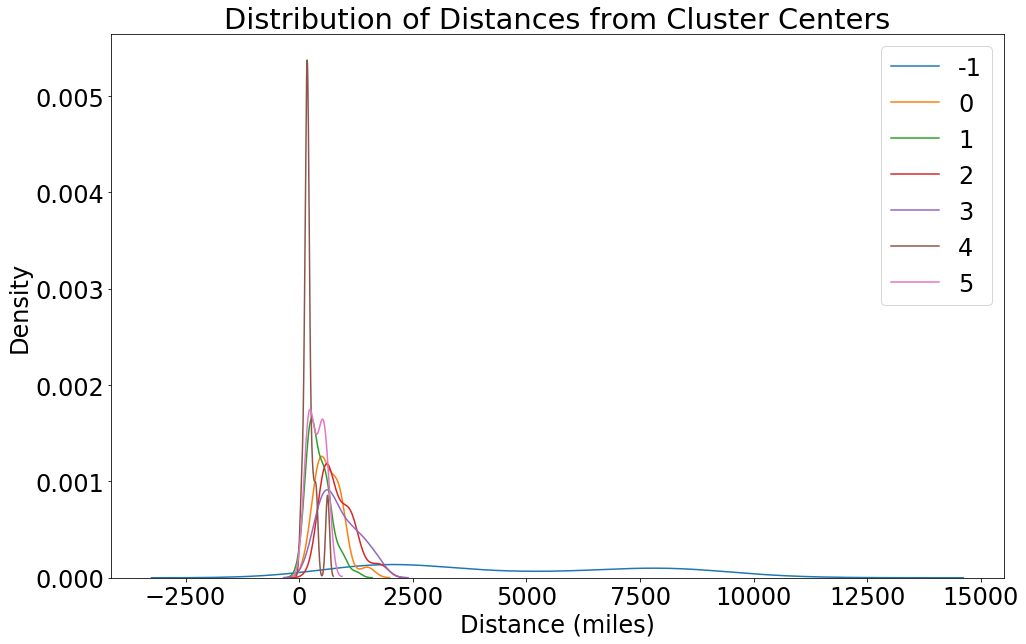

In [16]:
import seaborn as sns

plt.figure(figsize=(16, 10))

for cluster, grouped in world_data.groupby("cluster"):
    if len(grouped) < 10:
        continue
    else:
        sns.kdeplot(grouped["distance"], label=f"{cluster}")

ax = plt.gca()
_ = ax.set_title("Distribution of Distances from Cluster Centers")
_ = ax.set_xlabel("Distance (miles)")
_ = ax.set_ylabel("Density")

From this figure, we can see that cluster 3 is the most tightly grouped. Cluster 0 is multimodal with 2 peaks. The unassigned points are spread out as expected.

## Sort Clusters by Size and Distance to Center

To analyze the world clusters, we'll sort them by size descending and distance to the cluster center ascending.

In [17]:
world_data = world_data.sort_values(by=['count', 'distance'], ascending=[False, True])
world_data.head()

headline         city  latitude  \
95                       Influenza Exposure in Muscat       Muscat  23.58413   
47  Authorities are Worried about the Spread of No...        Dubai  25.07725   
91                        Chlamydia Exposure in Sanaa        Sanaa  15.35472   
46               Mecca tests new cure for Chikungunya        Mecca  21.42664   
84           Will Rotavirus vaccine help Addis Ababa?  Addis Ababa   9.02497   

    longitude countrycode  cluster         x         y  count  \
95   58.40778          OM       -1  58.40778  23.58413     76   
47   55.30927          AE       -1  55.30927  25.07725     76   
91   44.20667          YE       -1  44.20667  15.35472     76   
46   39.82563          SA       -1  39.82563  21.42664     76   
84   38.74689          ET       -1  38.74689   9.02497     76   

    longitude_cluster_center  latitude_cluster_center  x_cluster_center  \
95                 55.971291                 14.62281         55.971291   
47                 55.971291                 14.62281         55.971291   
91                 55.971291                 14.62281         55.971291   
46                 55.971291                 14.62281         55.971291   
84                 55.971291                 14.62281         55.971291   

    y_cluster_center     distance  
95          14.62281   638.775048  
47          14.62281   723.103494  
91          14.62281   786.180771  
46          14.62281  1158.436464  
84          14.62281  1225.844449

The noise (no cluster) is the largest by number of points. Within each cluster, we sort by the distance to the cluster center.

In [18]:
world_data.tail()

headline         city  latitude  \
294                      Vericella spreading in Ibadan       Ibadan   7.37756   
298                  Ibadan tests new cure for Malaria       Ibadan   7.37756   
296  The Spread of Malaria in Brazzaville has been ...  Brazzaville  -4.26613   
299                    Pneumonia has not Left Kinshasa     Kinshasa  -4.32758   
297                           Tuberculosis Hits Luanda       Luanda  -8.83682   

     longitude countrycode  cluster         x        y  count  \
294    3.90591          NG        6   3.90591  7.37756      9   
298    3.90591          NG        6   3.90591  7.37756      9   
296   15.28318          CG        6  15.28318 -4.26613      9   
299   15.31357          CD        6  15.31357 -4.32758      9   
297   13.23432          AO        6  13.23432 -8.83682      9   

     longitude_cluster_center  latitude_cluster_center  x_cluster_center  \
294                  9.285158                 1.910806          9.285158   
298                  9.285158                 1.910806          9.285158   
296                  9.285158                 1.910806          9.285158   
299                  9.285158                 1.910806          9.285158   
297                  9.285158                 1.910806          9.285158   

     y_cluster_center    distance  
294          1.910806  528.589012  
298          1.910806  528.589012  
296          1.910806  594.273277  
299          1.910806  598.774116  
297          1.910806  790.271756

As expected, our data is now sorted descending by the number of headlines within the cluster and ascending by the distance to the cluster center. 

# Look for Patterns in Headlines

For each cluster, we'll look at the top 5 headlines as measured by closest distance to the cluster center.

In [19]:
for cluster, grouped in world_data.groupby("cluster"):
    print("\nCluster", cluster)
    print("Number of headlines: ", len(grouped))
    print("Top 5 Headlines")
    print(list(grouped.nsmallest(n=5, columns="distance")["headline"]))


Cluster -1
Number of headlines:  76
Top 5 Headlines
['Influenza Exposure in Muscat', 'Authorities are Worried about the Spread of Norovirus in Dubai', 'Chlamydia Exposure in Sanaa', 'Mecca tests new cure for Chikungunya', 'Will Rotavirus vaccine help Addis Ababa?']

Cluster 0
Number of headlines:  22
Top 5 Headlines
['New Zika Case Confirmed in Belo Horizonte', 'Second Zika Paitient in Brasilia', 'Zika spreading to Salvador', 'More Zika patients reported in Camacari', 'Zika case reported in Jacobina']

Cluster 1
Number of headlines:  60
Top 5 Headlines
['More Livestock in Fontainebleau are infected with Mad Cow Disease', 'Scientists in Paris to look for answers', 'Mad Cow Disease Disastrous to Brussels', 'Sick Livestock Leads to Serious Trouble for Belfort', 'Will MCD vaccine help Strasbourg?']

Cluster 2
Number of headlines:  59
Top 5 Headlines
['Nha Trang Zika Outbreak', "Zika cases in Vietnam's Ho Chi Minh City surge", 'Zika Troubles come to Kampong Cham', 'More Zika patients repor

## World Disease Outbreaks

We have identified several outbreaks! Based on the headlines, we can draw the following conclusions about the clusters:


* -1: No outbreak
* 0: Zika outbreak
* 1: Mad Cow outbreak
* 2: Zika outbreak
* 3: No outbreak
* 4: No outbreak
* 5: Zika outbreak
* 6: No outbreak


Next, we want to locate each outbreak. We'll do this by visualizing them on a map.

## Visualizing World Outbreaks

We can use the same visualization function as before but label based on the outbreak. We can also create a column for the outbreak associated with the cluster. At this point, we'll only plot the data in a disease cluster.

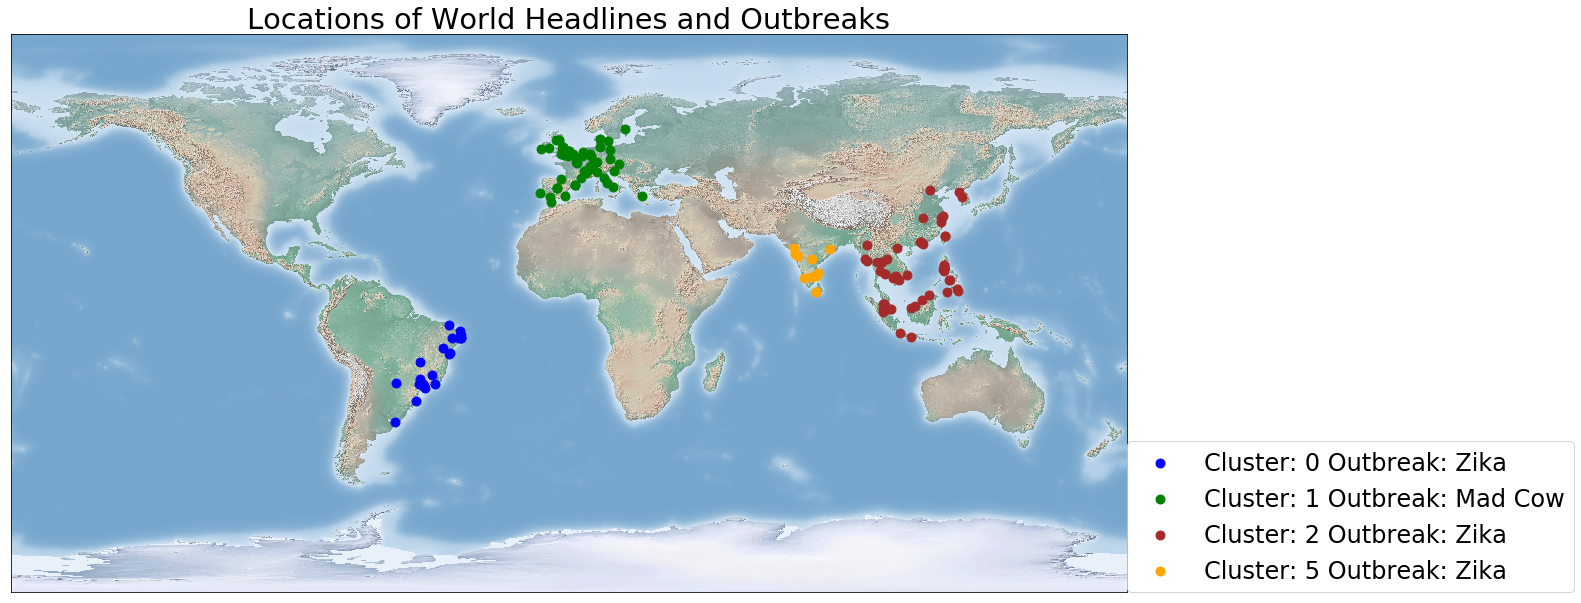

In [20]:
world_outbreak_mapping = {0: "Zika", 1: "Mad Cow", 2: "Zika", 5: "Zika"}

plot_clusters(
    world_data[world_data["cluster"].isin(world_outbreak_mapping.keys())],
    label_outbreak=world_outbreak_mapping,
)
ax = plt.gca()
_ = ax.set_title("Locations of World Headlines and Outbreaks")

We now can make the following observations:

* There is a Zika outbreak on the East Coast of South America
* There is a Zika outbreak in East Asia
* There is a Mad Cow outbreak in Europe
* There is a Zika outbreak in India

Let's look at the total number of headlines associated with each disease according to the clustering.

In [21]:
world_data["disease"] = world_data["cluster"].map(world_outbreak_mapping)
world_data["disease"].value_counts()

Zika       92
Mad Cow    60
Name: disease, dtype: int64

Now that we've identified the worldwide outbreaks, it's time to move on to the US. The procedure is much the same: find cluster centroids, find distance of headlines to cluster centroids, examine closest headlines to centers, determine if there is an outbreak in from the cluster, visualize the clusters with outbreaks, make conclusions!

# Analysis of United States Outbreaks

First let's find the information about each cluster.

In [22]:
us_clusters = analyze_clusters(us_data, us_m)
us_clusters[:2]

[{'cluster': -1,
  'count': 51,
  'longitude': -103.33012768583086,
  'latitude': 39.10930235030643,
  'x': 1822697.1534123302,
  'y': 1614944.0249390802},
 {'cluster': 0,
  'count': 42,
  'longitude': -81.3584018864898,
  'latitude': 27.428411397401486,
  'x': 3897123.0324733746,
  'y': 384145.4807333797}]

Let's spot check the cluster centers for correctness on a map.

In [23]:
plot_clusters(us_data, plot_us=True, cluster_centers=us_clusters)

OSError: cannot locate ./data/st99_d00_shp/st99_d00.shp

<Figure size 1440x1008 with 0 Axes>

Those look to be right on point. Now we join the cluster centers to the headline data.

In [24]:
us_data = us_data.merge(
    pd.DataFrame(us_clusters), on=["cluster"], suffixes=["", "_cluster_center"]
)
us_data.head()

headline         city  latitude  longitude  \
0                Zika Outbreak Hits Miami        Miami  25.77427  -80.19366   
1       First Case of Zika in Miami Beach  Miami Beach  25.79065  -80.13005   
2    Orlando volunteers aid Zika research      Orlando  28.53834  -81.37924   
3   Tampa Bay Area Zika Case Count Climbs        Tampa  27.94752  -82.45843   
4  Tallahassee Doctors Discuss Zika Virus  Tallahassee  30.43826  -84.28073   

  countrycode  cluster             x              y  count  \
0          US        0  4.042660e+06  217678.904462     42   
1          US        0  4.048770e+06  220569.071978     42   
2          US        0  3.876399e+06  507404.582832     42   
3          US        0  3.780084e+06  426282.635799     42   
4          US        0  3.567415e+06  680643.257184     42   

   longitude_cluster_center  latitude_cluster_center  x_cluster_center  \
0                -81.358402                27.428411      3.897123e+06   
1                -81.358402                27.428411      3.897123e+06   
2                -81.358402                27.428411      3.897123e+06   
3                -81.358402                27.428411      3.897123e+06   
4                -81.358402                27.428411      3.897123e+06   

   y_cluster_center  
0     384145.480733  
1     384145.480733  
2     384145.480733  
3     384145.480733  
4     384145.480733

### Distance from Headlines to Cluster Centers

Next, we can use our Haversine function to find the distance between each headline and its cluster center.

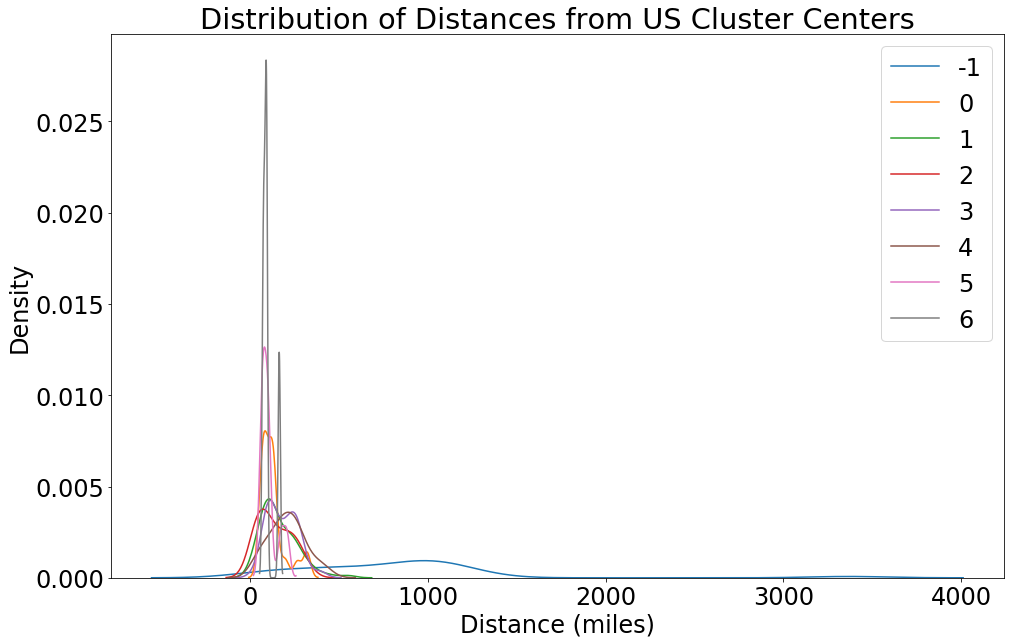

In [25]:
us_data["distance"] = haversine_formula_two_arrays(
    us_data["longitude"],
    us_data["latitude"],
    us_data["longitude_cluster_center"],
    us_data["latitude_cluster_center"],
)

plt.figure(figsize=(16, 10))

for cluster, grouped in us_data.groupby("cluster"):
    sns.kdeplot(grouped["distance"], label=f"{cluster}")

ax = plt.gca()
_ = ax.set_title("Distribution of Distances from US Cluster Centers")
_ = ax.set_xlabel("Distance (miles)")
_ = ax.set_ylabel("Density")

The United States clusters are in general more tightly grouped than those on the world. Again, the unassigned points have the largest spread in distance from cluster centers.

In [26]:
us_data = us_data.sort_values(by=['count', 'distance'], ascending=[False, True])
us_data.head()

headline          city  \
44                 Philadelphia experts track pandemic  Philadelphia   
110                How to Avoid Hepatitis B in Trenton       Trenton   
96   Vineland authorities confirmed the spread of C...      Vineland   
90   Schools in Bridgeton Closed Due to Mumps Outbreak     Bridgeton   
99      Princeton Encounters Severe Symptoms of Dengue     Princeton   

     latitude  longitude countrycode  cluster             x             y  \
44   39.95233  -75.16379          US        1  4.204920e+06  1.858252e+06   
110  40.21705  -74.74294          US        1  4.233264e+06  1.894614e+06   
96   39.48623  -75.02573          US        1  4.227584e+06  1.810489e+06   
90   39.42734  -75.23408          US        1  4.211631e+06  1.800273e+06   
99   40.34872  -74.65905          US        1  4.236940e+06  1.910384e+06   

     count  longitude_cluster_center  latitude_cluster_center  \
44      74                -75.308536                40.008379   
110     74                -75.308536                40.008379   
96      74                -75.308536                40.008379   
90      74                -75.308536                40.008379   
99      74                -75.308536                40.008379   

     x_cluster_center  y_cluster_center   distance  
44       4.191605e+06      1.861659e+06   8.580351  
110      4.191605e+06      1.861659e+06  33.159464  
96       4.191605e+06      1.861659e+06  39.052959  
90       4.191605e+06      1.861659e+06  40.312373  
99       4.191605e+06      1.861659e+06  41.546347

In [27]:
us_data.tail()

headline         city  latitude  \
302             Case of Measles Reported in Springdale   Springdale  36.18674   
303  Schools in Bentonville Closed Due to Hepatitis...  Bentonville  36.37285   
300            Spike of Pneumonia Cases in Springfield  Springfield  37.21533   
301         Benton Residents Recieve Pneumonia vaccine       Benton  34.56454   
304    Memphis Encounters Severe Symptoms of Swine Flu      Memphis  35.14953   

     longitude countrycode  cluster             x             y  count  \
302  -94.12881          US        6  2.614341e+06  1.259252e+06      5   
303  -94.20882          US        6  2.607012e+06  1.279791e+06      5   
300  -93.29824          US        6  2.686426e+06  1.374129e+06      5   
301  -92.58683          US        6  2.756891e+06  1.082038e+06      5   
304  -90.04898          US        6  2.984978e+06  1.156196e+06      5   

     longitude_cluster_center  latitude_cluster_center  x_cluster_center  \
302                -92.844299                35.907463      2.729849e+06   
303                -92.844299                35.907463      2.729849e+06   
300                -92.844299                35.907463      2.729849e+06   
301                -92.844299                35.907463      2.729849e+06   
304                -92.844299                35.907463      2.729849e+06   

     y_cluster_center    distance  
302      1.230246e+06   74.255028  
303      1.230246e+06   82.590741  
300      1.230246e+06   93.745124  
301      1.230246e+06   93.852276  
304      1.230246e+06  165.551902

Our largest cluster is no longer the noise (it's the smallest cluster for the United States). Let's now try to find if the cluster headlines share common disease mentions.

## Examine Headlines from Each Cluster

Let's look at the 10 headlines closest to each cluster center.

In [28]:
for cluster, grouped in us_data.groupby("cluster"):
    print("\nCluster", cluster)
    print("Number of headlines: ", len(grouped))
    print("Top 10 Headlines")
    print(list(grouped.nsmallest(n=10, columns="distance")["headline"]))


Cluster -1
Number of headlines:  51
Top 10 Headlines
['Case of Malaria Reported in Aurora', 'Chikungunya Hits Denver', 'Lower Hospitalization in Lakewood after Hepatitis B Vaccine becomes Mandatory', 'Arvada is infested with Syphilis', 'Spike of Hepatitis C Cases in Golden', 'HIV Keeps Spreading in Boulder', 'Fort Collins Encounters Severe Symptoms of Gonorrhea', 'Rumors about Rotavirus spreading in North Platte have been refuted', 'Spike of Chlamydia Cases in Farmington', 'Spike of Tuberculosis Cases in Albuquerque']

Cluster 0
Number of headlines:  42
Top 10 Headlines
['More Zika patients reported in Lakeland', 'Zika spreads to Kissimmee', 'Zika spreads to Plant City', 'More Zika patients reported in Fort Myers', 'Zika reported in Fort Pierce', 'New Zika Case Confirmed in Sarasota County', 'Bradenton Experiences Zika Troubles', 'Tampa Bay Area Zika Case Count Climbs', 'Orlando volunteers aid Zika research', 'Zika symptoms spotted in Bonita Springs']

Cluster 1
Number of headlines:  

There are only 2 clusters with repeated disease mentions in the United States. Both of them are associated with Zika. 

* Cluster -1: No outbreak
* Cluster 0: Zika Outbreak
* Cluster 1: No outbreak
* Cluster 2: Zika Outbreak
* Cluster 3: No outbreak
* Cluster 4: No outbreak
* Cluster 5: No outbreak
* Cluster 6: No outbreak

Let's update the cluster map to show the United States outbreaks.

In [29]:
us_outbreak_mapping = {0: "Zika", 2: "Zika"}

plot_clusters(
    us_data[us_data["cluster"].isin(us_outbreak_mapping.keys())],
    plot_us=True,
    label_outbreak=us_outbreak_mapping,
)
ax = plt.gca()
_ = ax.set_title("Locations of US Headlines and Outbreaks")

OSError: cannot locate ./data/st99_d00_shp/st99_d00.shp

<Figure size 1440x1008 with 0 Axes>

We can draw the following conclusions about the United States:

* A Zika outbreak in Texas
* A Zika outbreak in the Eastern South

Let's look at the value counts of US disease clusters.

In [30]:
us_data['disease'] = us_data['cluster'].map(us_outbreak_mapping)
us_data['disease'].value_counts()

Zika    63
Name: disease, dtype: int64

# Final Plot of Worldwide Outbreak

First, we'll join together the US and world data, keeping only those that were in a Zika cluster. 

## Find All Zika Cases

Now that we have determined zika is the major disease outbreak, we can find all mentions using simple text matching. We can use Pandas string methods to find the headlines mentioning Zika and plot these.

In [31]:
zika_data = pd.concat([us_data, world_data])

# Keep only headlines matching "Zika"
zika_data = zika_data[zika_data["headline"].str.lower().str.contains('zika', na=False)]

We can look at the distribution of Zika cases by cluster in the US and around the world.

In [32]:
zika_world = zika_data[zika_data["countrycode"] != "US"]
print(f"There are {len(zika_world)} Zika cases around the world.")

zika_us = zika_data[zika_data["countrycode"] == "US"]
print(f"There are {len(zika_us)} Zika cases in the United States.")

There are 119 Zika cases around the world.
There are 91 Zika cases in the United States.


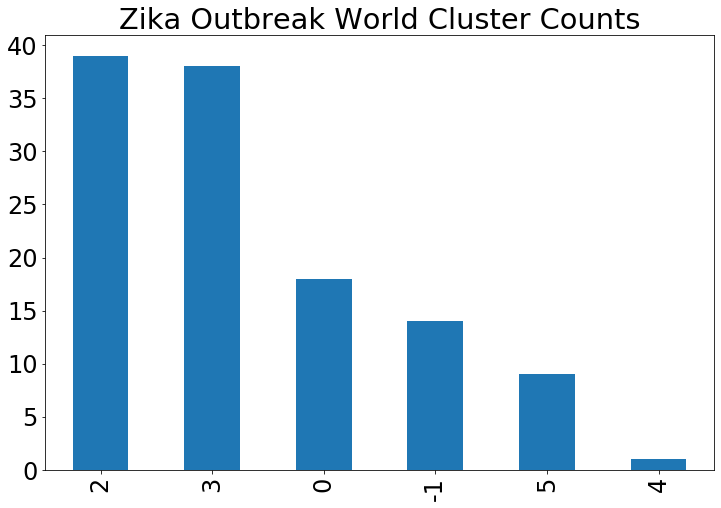

In [33]:
_ = (
    zika_world["cluster"]
    .value_counts()
    .plot.bar(title="Zika Outbreak World Cluster Counts", figsize=(12, 8))
)

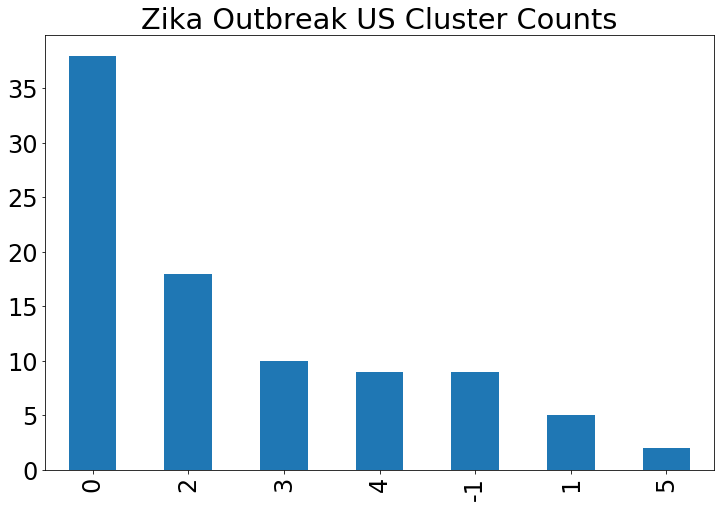

In [34]:
_ = (
    zika_us["cluster"]
    .value_counts()
    .plot.bar(title="Zika Outbreak US Cluster Counts", figsize=(12, 8))
)

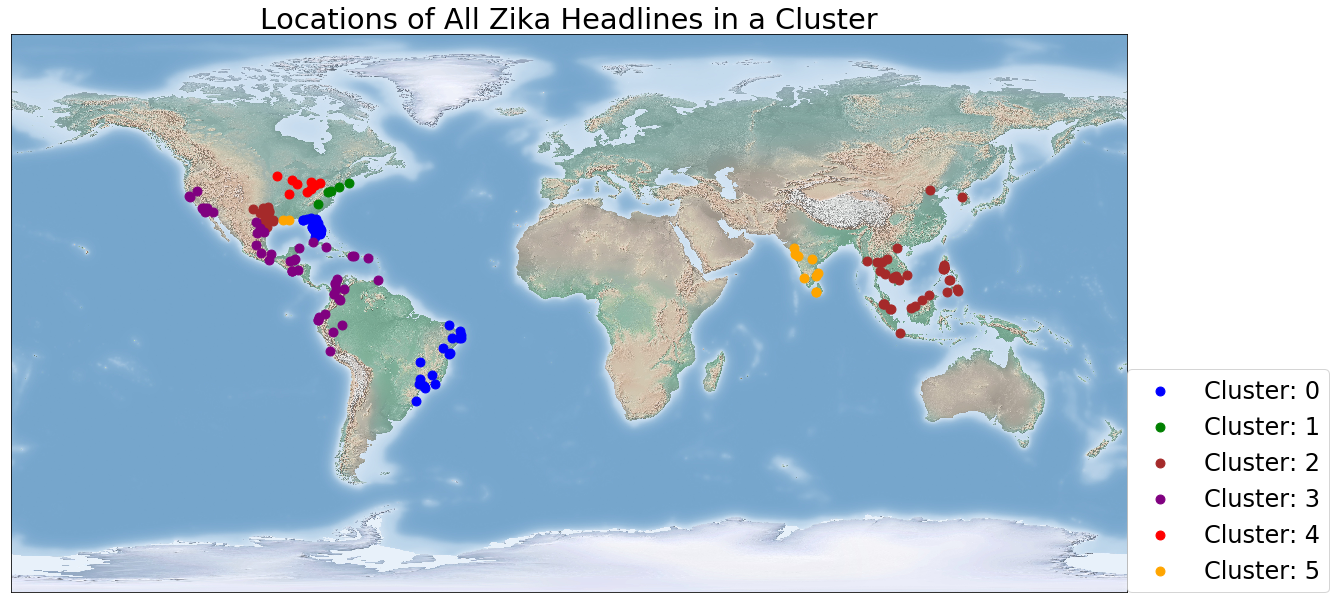

In [35]:
zika_data["x"], zika_data["y"] = world_m(
    x=zika_data["longitude"], y=zika_data["latitude"]
)

plot_clusters(zika_data[zika_data['cluster'] != -1])
ax = plt.gca()
_ = ax.set_title("Locations of All Zika Headlines in a Cluster")

We can clearly see there are 4 major outbreaks:

* South-eastern United States and Central America
* Eastern South America
* India
* Oceania and Eastern Asia

These are the areas to which we should direct medical assistance!

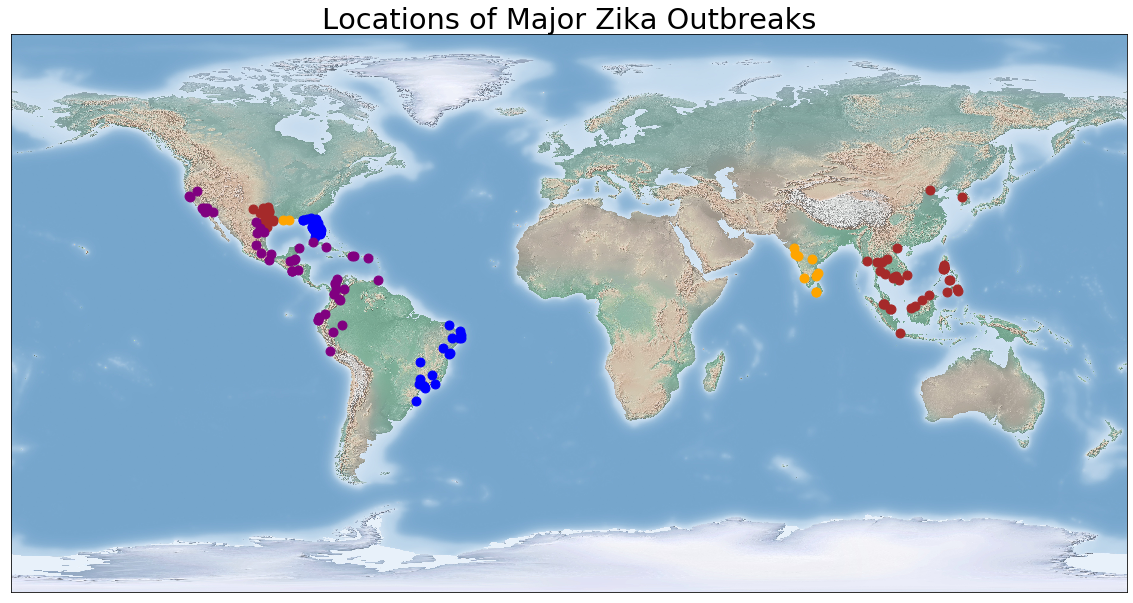

In [36]:
major_clusters = zika_data[zika_data['cluster'].isin([0, 2, 3, 5])]
plot_clusters(major_clusters)
ax = plt.gca()
_ = ax.set_title("Locations of Major Zika Outbreaks");
ax.get_legend().remove()
plt.savefig('./figs/completed_map.png');

We can add up the number of headlines in each cluster. We'll have to combine those in the US and Central America using the map and the counts.

In [37]:
zika_us[zika_us['cluster'].isin([0, 2, 3, 5])]['cluster'].value_counts()

0    38
2    18
3    10
5     2
Name: cluster, dtype: int64

In [38]:
zika_world[zika_world['cluster'].isin([0, 2, 3, 5])]['cluster'].value_counts()

2    39
3    38
0    18
5     9
Name: cluster, dtype: int64

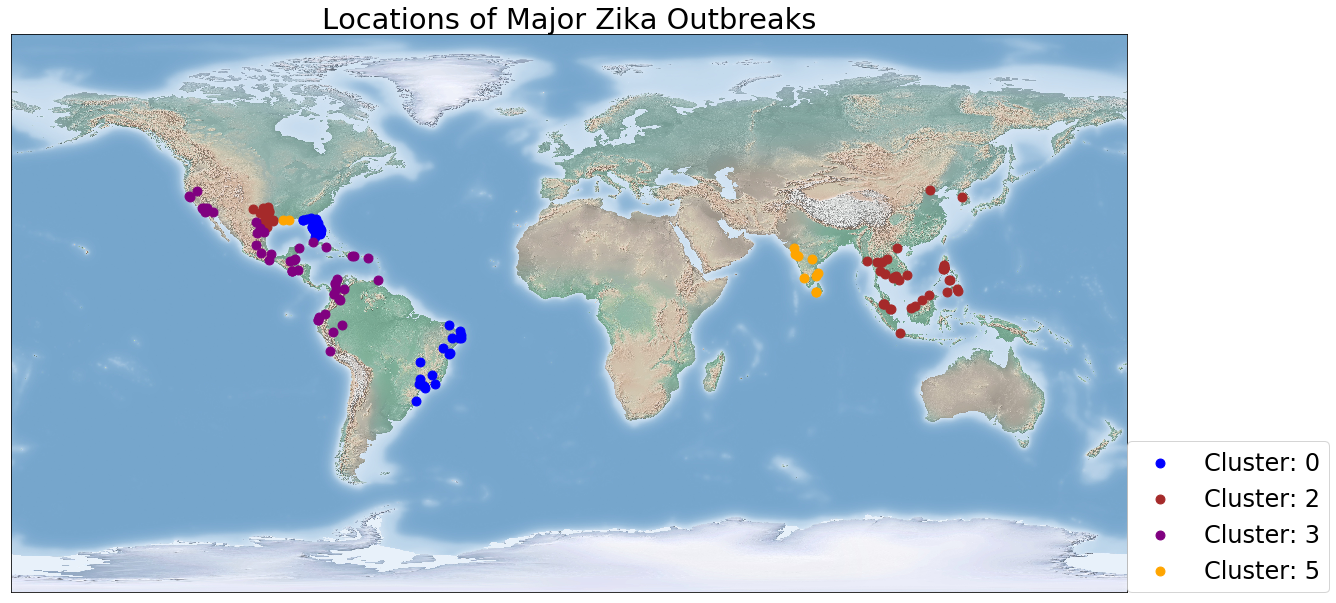

In [39]:
plot_clusters(major_clusters)
ax = plt.gca()
_ = ax.set_title("Locations of Major Zika Outbreaks");
plt.savefig('./figs/final_outbreak_map.png')

### Counts of Zika Cases in Each Outbreak

These are the counts of headlines in each Zika outbreak. While not all of the headlines may have to do with a specific case, the relative numbers should allow our superiors to prioritize where help is directed.

* Mid-South United States and Central America: 106 headlines
* East Asia: 39 headlines
* Eastern South America: 18 headlines
* India: 9 headlines

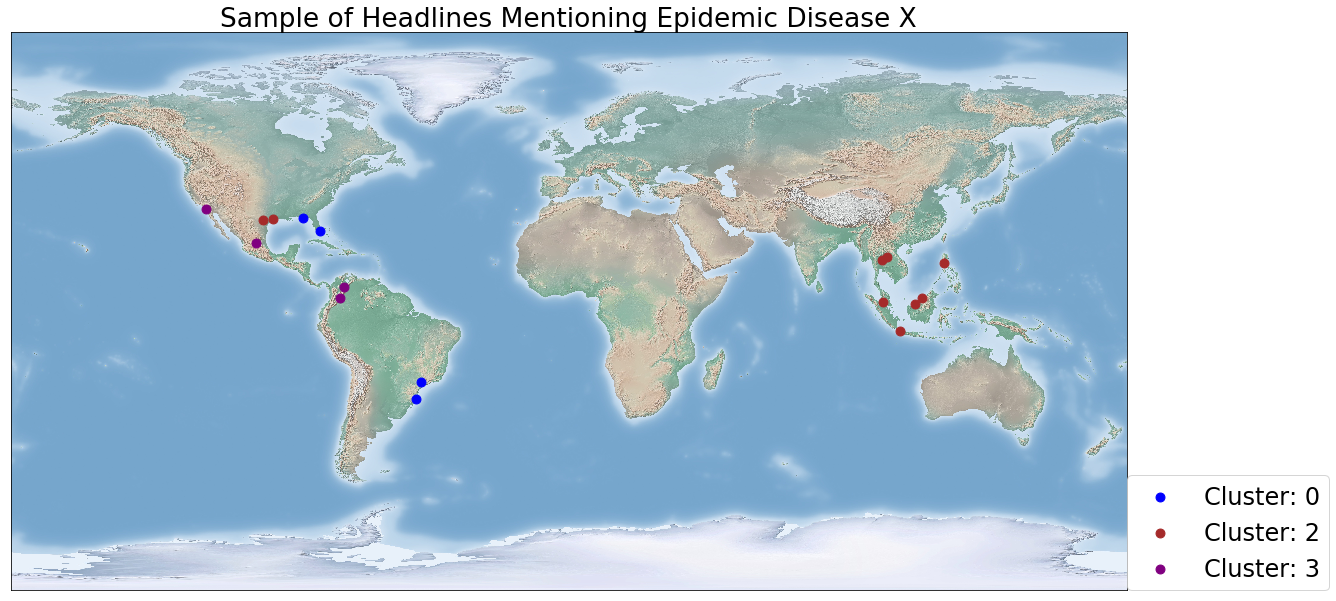

In [40]:
plot_clusters(zika_data[zika_data['cluster'].isin([0, 2, 3, 5])].sample(frac=0.1))
ax = plt.gca()
plt.rcParams['font.size'] = 22
_ = ax.set_title("Sample of Headlines Mentioning Epidemic Disease X")

We can only make this plot if we know the disease we are looking for ahead of time! Clustering is useful because it allowed us to extract patterns in the data without us knowing what exactly to look for, that is, we did not need to know the specific disease. 

In [41]:
zika_data.to_csv("./data/zika_outbreaks.csv")
major_clusters.to_csv('./data/major_clusters.csv')

# Output

The end output from this section is a listing of the headlines in the major disease outbreaks along with a world map of the same headlines. The text information can be used for further analysis, and the map shows an overview of the issue (and would make for a good graphic in an article). We will place this map in the Executive Summary. 

In [42]:
zika_data[zika_data['cluster'].isin([0, 2, 3, 5])][['headline', 'city', 'latitude', 'longitude', 'countrycode', 'cluster']].head(10)

headline           city  \
263                 Zika symptoms spotted in Hollywood      Hollywood   
255                      Zika Virus Arrives in Ontario        Ontario   
273                        Zika arrives in Orange City         Orange   
265                   Outbreak of Zika in Palm Springs   Palm Springs   
251  Escondido neighborhood to get sprayed for Zika...      Escondido   
244           Key Zika Findings in San Diego Institute      San Diego   
252                     Zika in Belmont, Belmont worry        Belmont   
245                   Zika Virus Reaches San Francisco  San Francisco   
290                       Zika seminars in Yuma County           Yuma   
261          Zika Virus Sparks 'International Concern'         Sparks   

     latitude  longitude countrycode  cluster  
263  34.09834 -118.32674          US        3  
255  34.06334 -117.65089          US        3  
273  33.78779 -117.85311          US        3  
265  33.83030 -116.54529          US        3  
251  33.11921 -117.08642          US        3  
244  32.71571 -117.16472          US        3  
252  37.52021 -122.27580          US        3  
245  37.77493 -122.41942          US        3  
290  32.72532 -114.62440          US        3  
261  39.53491 -119.75269          US        3

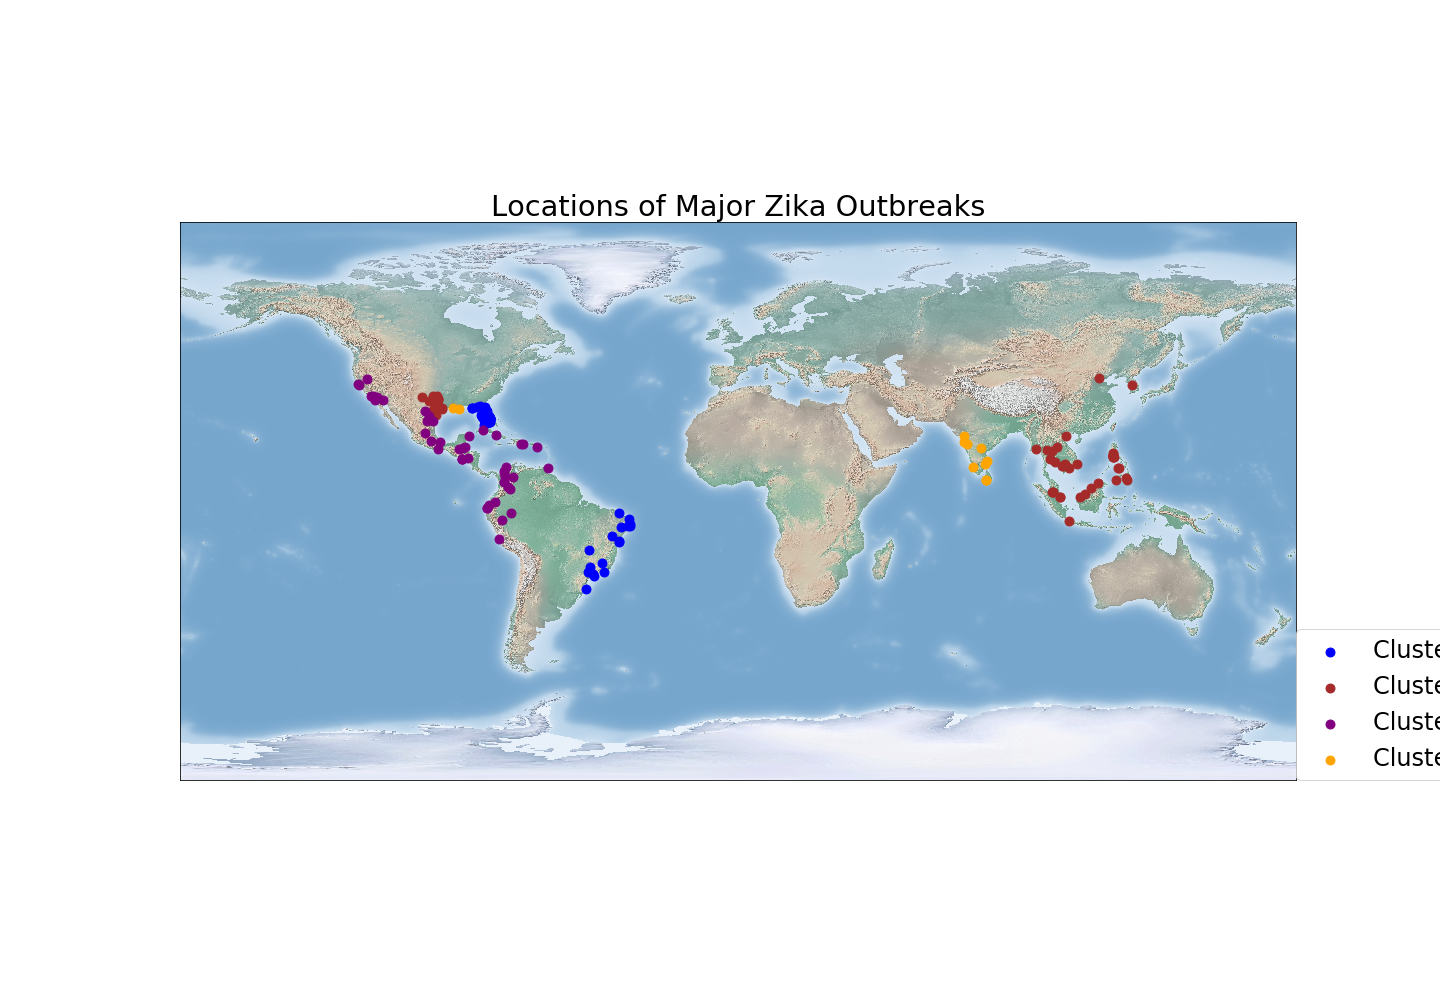

In [43]:
from IPython.display import Image

Image('./figs/final_outbreak_map.png')

In [44]:
zika_data.tail(10)

headline        city  latitude  \
290             More Zika patients reported in Chennai     Chennai  13.08784   
282                         Zika Outbreak in Hyderabad   Hyderabad  17.38405   
287                        Zika Outbreak in Puducherry  Puducherry  11.93381   
288                      Outbreak of Zika in Kozhikode   Kozhikode  11.24802   
272            Tests negative on Windsor Zika carriers     Windsor  42.30008   
281                     Pune woman diagnosed with Zika        Pune  18.51957   
280  Mumbai's Health Minister warns of more Zika cases      Mumbai  19.07283   
283                   Zika symptoms spotted in Colombo     Colombo   6.93548   
289                        Outbreak of Zika in Colombo     Colombo   6.93548   
286                     Zika symptoms spotted in Surat       Surat  21.19594   

     longitude countrycode  cluster         x         y  count  \
290   80.27847          IN        5  80.27847  13.08784     11   
282   78.45636          IN        5  78.45636  17.38405     11   
287   79.82979          IN        5  79.82979  11.93381     11   
288   75.78040          IN        5  75.78040  11.24802     11   
272  -83.01654          CA        4 -83.01654  42.30008     11   
281   73.85535          IN        5  73.85535  18.51957     11   
280   72.88261          IN        5  72.88261  19.07283     11   
283   79.84868          LK        5  79.84868   6.93548     11   
289   79.84868          LK        5  79.84868   6.93548     11   
286   72.83023          IN        5  72.83023  21.19594     11   

     longitude_cluster_center  latitude_cluster_center  x_cluster_center  \
290                 77.850840                 14.46198         77.850840   
282                 77.850840                 14.46198         77.850840   
287                 77.850840                 14.46198         77.850840   
288                 77.850840                 14.46198         77.850840   
272                -76.311299                 44.69563        -76.311299   
281                 77.850840                 14.46198         77.850840   
280                 77.850840                 14.46198         77.850840   
283                 77.850840                 14.46198         77.850840   
289                 77.850840                 14.46198         77.850840   
286                 77.850840                 14.46198         77.850840   

     y_cluster_center    distance disease  
290          14.46198  188.420845    Zika  
282          14.46198  205.720674    Zika  
287          14.46198  219.461985    Zika  
288          14.46198  262.033830    Zika  
272          44.69563  374.193477     NaN  
281          14.46198  385.253912    Zika  
280          14.46198  457.328884    Zika  
283          14.46198  537.027454    Zika  
289          14.46198  537.027454    Zika  
286          14.46198  570.005566    Zika

We will use the map in the final Executive Summary. The information from the dataframe can be used to address the outbreaks.

# Conclusions

In this notebook, we:

* Separated the data into US and the World sets
* Clustered the datasets separately
    - Different parameters were required for each dataset
* Found the geographic centers of each cluster
* Found the distance of each headline to its respective cluster center
    - Used the Great Circle distance
* Analyzed the headlines closest to each cluster center to find diseases associated with the cluster
* Discovered outbreaks of Zika in the United States and worldwide
* Identified and visualized 4 major outbreaks of Zika around the world
    - Counted the cases in each headline

The end deliverable is a map of the major outbreaks of Zika around the world. We could use these maps to identify areas most in need of assistance.

The executive summary covers the main takeaways from this project. Overall, this project provided great practice in a number of crucial data science skills including delivering a useable end product.